In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle

In [3]:
shutil.copytree('drive/MyDrive/JHU_Courses/Deep_Learning/Project/frames_1fps_resize_zip', 'frames_1fps_resize_zip')

'frames_1fps_resize_zip'

In [4]:
cd frames_1fps_resize_zip

/content/frames_1fps_resize_zip


In [5]:
!unzip frames-1fps-resize.zip

Streaming output truncated to the last 5000 lines.
  inflating: frames-1fps-resize/video79/video79-1123.jpg  
  inflating: frames-1fps-resize/video79/video79-1124.jpg  
  inflating: frames-1fps-resize/video79/video79-1125.jpg  
  inflating: frames-1fps-resize/video79/video79-1126.jpg  
  inflating: frames-1fps-resize/video79/video79-1127.jpg  
  inflating: frames-1fps-resize/video79/video79-1128.jpg  
  inflating: frames-1fps-resize/video79/video79-1129.jpg  
  inflating: frames-1fps-resize/video79/video79-113.jpg  
  inflating: frames-1fps-resize/video79/video79-1130.jpg  
  inflating: frames-1fps-resize/video79/video79-1131.jpg  
  inflating: frames-1fps-resize/video79/video79-1132.jpg  
  inflating: frames-1fps-resize/video79/video79-1133.jpg  
  inflating: frames-1fps-resize/video79/video79-1134.jpg  
  inflating: frames-1fps-resize/video79/video79-1135.jpg  
  inflating: frames-1fps-resize/video79/video79-1136.jpg  
  inflating: frames-1fps-resize/video79/video79-1137.jpg  
  infl

In [6]:
cd ..

/content


In [7]:
project_path = "drive/MyDrive/JHU_Courses/Deep_Learning/Project"

In [8]:
# get paths and labels
img_dir = 'frames_1fps_resize_zip/frames-1fps-resize/'
tool_dir = project_path+'/Dataset/cholec80/tool_annotations'
phase_dir = project_path+'/Dataset/cholec80/phase_annotations'

def get_dirs(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

def get_files(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if not os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

img_dir_names, img_dir_paths = get_dirs(img_dir)
tool_file_names, tool_file_paths = get_files(tool_dir)
phase_file_names, phase_file_paths = get_files(phase_dir)

phase_dict = {}
phase_dict_key = ['Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']
for i in range(len(phase_dict_key)):
    phase_dict[phase_dict_key[i]] = i
print(phase_dict)

all_info_all = []

for j in range(len(tool_file_names)):
    last_tool_index = ''
    last_phase_index = ''
    tool_file = open(tool_file_paths[j])
    phase_file = open(phase_file_paths[j])
    tool_count = 0
    phase_count = 0
    info_all = []
    for tool_line in tool_file:
        tool_count += 1
        if tool_count > 1:
            tool_split = tool_line.split()
            info_each = []
            img_file_each_path = os.path.join(img_dir_paths[j], img_dir_names[j] + '-' + str(tool_count - 1) + '.jpg')
            info_each.append(img_file_each_path)
            for l in range(1, len(tool_split)):
                info_each.append(int(tool_split[l]))
                last_tool_index = tool_split[0]
            info_all.append(info_each)
            #print(info_each)
    for phase_line in phase_file:
        phase_count += 1
        if phase_count % 25 == 2 and (phase_count // 25) < len(info_all):
            phase_split = phase_line.split()
            info_all[phase_count // 25].append(phase_dict[phase_split[1]])
            # print(info_all[phase_count // 25])
            last_phase_index = phase_split[0]
    print('the{:4d}th tool: {:6d} index_error{:2d}'.format(j, tool_count - 1, int(last_tool_index) - int(last_phase_index)))

    #print(len(info_all))
    all_info_all.append(info_all)

with open('cholec80.pkl', 'wb') as f:
    pickle.dump(all_info_all, f)

with open('cholec80.pkl', 'rb') as f:
    all_info = pickle.load(f)

print(all_info[0][0])
print(all_info[79][0])

train_file_paths = []
test_file_paths = []
val_file_paths = []
val_labels = []
train_labels = []
test_labels = []

train_num_each = []
val_num_each = []
test_num_each = []

for i in range(32):
    train_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        train_file_paths.append(all_info[i][j][0])
        train_labels.append(all_info[i][j][1:])

print(len(train_file_paths))
print(len(train_labels))

for i in range(32, 40):
    val_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        val_file_paths.append(all_info[i][j][0])
        val_labels.append(all_info[i][j][1:])

print(len(val_file_paths))
print(len(val_labels))

for i in range(40, 80):
    test_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        test_file_paths.append(all_info[i][j][0])
        test_labels.append(all_info[i][j][1:])

print(len(test_file_paths))
print(len(test_labels))

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_file_paths)
train_val_test_paths_labels.append(val_file_paths)
train_val_test_paths_labels.append(test_file_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)
train_val_test_paths_labels.append(test_labels)

train_val_test_paths_labels.append(train_num_each)
train_val_test_paths_labels.append(val_num_each)
train_val_test_paths_labels.append(test_num_each)

with open('train_val_test_paths_labels.pkl', 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

{'Preparation': 0, 'CalotTriangleDissection': 1, 'ClippingCutting': 2, 'GallbladderDissection': 3, 'GallbladderPackaging': 4, 'CleaningCoagulation': 5, 'GallbladderRetraction': 6}
the   0th tool:   1733 index_error 0
the   1th tool:   2839 index_error 0
the   2th tool:   5828 index_error 0
the   3th tool:   1522 index_error 0
the   4th tool:   2344 index_error 0
the   5th tool:   2153 index_error 0
the   6th tool:   4557 index_error 0
the   7th tool:   1519 index_error 0
the   8th tool:   2702 index_error 0
the   9th tool:   1749 index_error 0
the  10th tool:   3220 index_error 0
the  11th tool:   1090 index_error 0
the  12th tool:    981 index_error 0
the  13th tool:   1708 index_error 0
the  14th tool:   2058 index_error 0
the  15th tool:   2957 index_error 0
the  16th tool:   1304 index_error 0
the  17th tool:   1942 index_error 0
the  18th tool:   2424 index_error 0
the  19th tool:   1449 index_error 0
the  20th tool:   1258 index_error 0
the  21th tool:   1532 index_error 0
the  2

In [9]:
execfile(project_path+"/two_networks_two_tasks/utils.py")

In [10]:
execfile(project_path+"/two_networks_two_tasks/Model.py")

In [11]:
# param
train_batch_size = 40
val_batch_size = 8
test_batch_size = 8
workers = 2
learning_rate = 1e-3
epochs = 25

train_batch_size = 100
val_batch_size = 20
test_batch_size = 20
workers=mp.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
# Load Data
train_dataset, train_num_each, val_dataset, val_num_each, test_dataset, test_num_each = get_data('train_val_test_paths_labels.pkl')
train_loader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
val_loader = DataLoader(val_dataset,batch_size=val_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,num_workers=workers, pin_memory=False)

train_paths  :  71000
train_labels :  71000
valid_paths  :  15304
valid_labels :  15304
test_paths   :  98194
test_labels  :  98194


In [13]:
# Model
model = LSTM_ResNet()
model.cuda()

# loss_f optimizer
tool_loss_f = nn.BCEWithLogitsLoss(size_average=False)
phase_loss_f = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 292MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.for

In [14]:
loss_log = pd.DataFrame([], index=[], columns=['Epoch', 'Train Tool Loss', 'Val Tool Loss', 'Test Tool Loss', 'Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
acc_log = pd.DataFrame([], index=[], columns=['Epoch', 'Train Tool Acc', 'Val Tool Acc',' Test Tool Acc', 'Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])

In [15]:
Best_Acc = 0.0

In [16]:
for epoch in range(epochs):
  print("epoch" + str(epoch))
  train_tool_loss_list = []
  train_tool_acc_list = []
  train_phase_loss_list = []
  train_phase_acc_list = []

  val_tool_loss_list = []
  val_tool_acc_list = []
  val_phase_loss_list = []
  val_phase_acc_list = []

  test_tool_loss_list = []
  test_tool_acc_list = []
  test_phase_loss_list = []
  test_phase_acc_list = []
  # train
  model.train()
  for data in tqdm(train_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    optimizer.zero_grad()
    tool_output, phase_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)

    loss = tool_loss + phase_loss
    loss.backward()
    optimizer.step()

  # valid
  model.eval()
  for data in tqdm(train_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    train_tool_loss_list.append(tool_loss.item())
    train_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    train_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    train_phase_acc_list.append(acc.data.cpu().numpy())

  print('Train Tool Loss:{:.4f} Train Phase Loss:{:.4f}'.format(np.mean(train_tool_loss_list),np.mean(train_phase_loss_list)))
  print('Train Tool Acc:{:.4f} Train Phase Acc:{:.4f}'.format(np.mean(train_tool_acc_list),np.mean(train_phase_acc_list)))

  for data in tqdm(val_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    val_tool_loss_list.append(tool_loss.item())
    val_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    val_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    val_phase_acc_list.append(acc.data.cpu().numpy())

  print('Val Tool Loss:{:.4f} Val Phase Loss:{:.4f}'.format(np.mean(val_tool_loss_list),
                                                                np.mean(val_phase_loss_list)))
  print('Val Tool Acc:{:.4f} Val Phase Acc:{:.4f}'.format(np.mean(val_tool_acc_list),
                                                              np.mean(val_phase_acc_list)))

  for data in tqdm(test_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    test_tool_loss_list.append(tool_loss.item())
    test_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    test_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    test_phase_acc_list.append(acc.data.cpu().numpy())

  print('Test Tool Loss:{:.4f} Test Phase Loss:{:.4f}'.format(np.mean(test_tool_loss_list),
                                                                np.mean(test_phase_loss_list)))
  print('Test Tool Acc:{:.4f} Test Phase Acc:{:.4f}'.format(np.mean(test_tool_acc_list),
                                                              np.mean(test_phase_acc_list)))

  # log
  tmp = pd.Series([epoch,np.mean(train_tool_loss_list),np.mean(val_tool_loss_list),np.mean(test_tool_loss_list),
                    np.mean(train_phase_loss_list),np.mean(val_phase_loss_list),np.mean(test_phase_loss_list)],
                  index=['Epoch', 'Train Tool Loss', 'Val Tool Loss','Test Tool Loss',
                                              'Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
  loss_log = loss_log.append(tmp, ignore_index=True)
  os.makedirs(project_path+'/two_networks_two_tasks/log',exist_ok=True)
  loss_log.to_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_loss_log.csv',index=False)

  tmp = pd.Series([epoch,np.mean(train_tool_acc_list),np.mean(val_tool_acc_list),np.mean(test_tool_acc_list),
                    np.mean(train_phase_acc_list),np.mean(val_phase_acc_list),np.mean(test_phase_acc_list)],
                  index=['Epoch', 'Train Tool Acc', 'Val Tool Acc','Test Tool Acc',
                                              'Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])
  acc_log = acc_log.append(tmp, ignore_index=True)
  acc_log.to_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_acc_log.csv',index=False)

  # save
  if np.mean(test_phase_acc_list) > Best_Acc:
      Best_Acc = np.mean(test_phase_acc_list)
      state_dict = model.state_dict()
      torch.save(state_dict, project_path+'/two_networks_two_tasks/log/multi_tasks_model.pkl')
      print('Successly Save Weight!!')


epoch0


100%|██████████| 710/710 [00:45<00:00, 15.56it/s]


Train Tool Loss:51.1139 Train Phase Loss:38.6984
Train Tool Acc:0.9733 Train Phase Acc:0.8613


100%|██████████| 766/766 [00:14<00:00, 52.04it/s]


Val Tool Loss:14.7890 Val Phase Loss:13.7922
Val Tool Acc:0.9569 Val Phase Acc:0.7643


100%|██████████| 4910/4910 [01:33<00:00, 52.49it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)


Test Tool Loss:23.8226 Test Phase Loss:17.5702
Test Tool Acc:0.9461 Test Phase Acc:0.7080


<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Successly Save Weight!!
epoch1


100%|██████████| 710/710 [00:46<00:00, 15.41it/s]


Train Tool Loss:44.5605 Train Phase Loss:28.4864
Train Tool Acc:0.9770 Train Phase Acc:0.8993


100%|██████████| 766/766 [00:15<00:00, 50.75it/s]


Val Tool Loss:16.0588 Val Phase Loss:16.5008
Val Tool Acc:0.9577 Val Phase Acc:0.7322


100%|██████████| 4910/4910 [01:33<00:00, 52.51it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:19.6972 Test Phase Loss:18.0123
Test Tool Acc:0.9547 Test Phase Acc:0.7092
Successly Save Weight!!
epoch2


100%|██████████| 710/710 [00:45<00:00, 15.54it/s]


Train Tool Loss:37.0010 Train Phase Loss:25.2545
Train Tool Acc:0.9805 Train Phase Acc:0.9105


100%|██████████| 766/766 [00:15<00:00, 49.92it/s]


Val Tool Loss:13.6917 Val Phase Loss:14.6817
Val Tool Acc:0.9630 Val Phase Acc:0.7570


100%|██████████| 4910/4910 [01:33<00:00, 52.29it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:22.3762 Test Phase Loss:16.7013
Test Tool Acc:0.9542 Test Phase Acc:0.7302
Successly Save Weight!!
epoch3


100%|██████████| 710/710 [00:45<00:00, 15.56it/s]


Train Tool Loss:42.9266 Train Phase Loss:30.8700
Train Tool Acc:0.9786 Train Phase Acc:0.8919


100%|██████████| 766/766 [00:14<00:00, 52.07it/s]


Val Tool Loss:14.8859 Val Phase Loss:14.4725
Val Tool Acc:0.9606 Val Phase Acc:0.7719


100%|██████████| 4910/4910 [01:33<00:00, 52.65it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.0228 Test Phase Loss:18.2692
Test Tool Acc:0.9474 Test Phase Acc:0.7296
epoch4


100%|██████████| 710/710 [00:45<00:00, 15.44it/s]


Train Tool Loss:25.3185 Train Phase Loss:14.2054
Train Tool Acc:0.9871 Train Phase Acc:0.9499


100%|██████████| 766/766 [00:14<00:00, 51.36it/s]


Val Tool Loss:13.1285 Val Phase Loss:13.8638
Val Tool Acc:0.9662 Val Phase Acc:0.7916


100%|██████████| 4910/4910 [01:32<00:00, 52.80it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.7201 Test Phase Loss:17.7438
Test Tool Acc:0.9509 Test Phase Acc:0.7378
Successly Save Weight!!
epoch5


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:25.6060 Train Phase Loss:15.3324
Train Tool Acc:0.9867 Train Phase Acc:0.9453


100%|██████████| 766/766 [00:14<00:00, 51.21it/s]


Val Tool Loss:13.2190 Val Phase Loss:14.1858
Val Tool Acc:0.9664 Val Phase Acc:0.7837


100%|██████████| 4910/4910 [01:33<00:00, 52.49it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.5433 Test Phase Loss:16.9247
Test Tool Acc:0.9551 Test Phase Acc:0.7475
Successly Save Weight!!
epoch6


100%|██████████| 710/710 [00:45<00:00, 15.55it/s]


Train Tool Loss:21.1729 Train Phase Loss:12.1819
Train Tool Acc:0.9894 Train Phase Acc:0.9556


100%|██████████| 766/766 [00:14<00:00, 51.12it/s]


Val Tool Loss:13.0900 Val Phase Loss:13.3901
Val Tool Acc:0.9665 Val Phase Acc:0.7901


100%|██████████| 4910/4910 [01:33<00:00, 52.64it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:22.6673 Test Phase Loss:17.4658
Test Tool Acc:0.9556 Test Phase Acc:0.7487
Successly Save Weight!!
epoch7


100%|██████████| 710/710 [00:45<00:00, 15.49it/s]


Train Tool Loss:20.0440 Train Phase Loss:11.6124
Train Tool Acc:0.9899 Train Phase Acc:0.9586


100%|██████████| 766/766 [00:15<00:00, 50.20it/s]


Val Tool Loss:13.7010 Val Phase Loss:15.2535
Val Tool Acc:0.9667 Val Phase Acc:0.7884


100%|██████████| 4910/4910 [01:33<00:00, 52.65it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.8787 Test Phase Loss:18.4461
Test Tool Acc:0.9585 Test Phase Acc:0.7565
Successly Save Weight!!
epoch8


100%|██████████| 710/710 [00:45<00:00, 15.51it/s]


Train Tool Loss:18.1770 Train Phase Loss:10.5849
Train Tool Acc:0.9906 Train Phase Acc:0.9621


100%|██████████| 766/766 [00:15<00:00, 50.73it/s]


Val Tool Loss:13.8603 Val Phase Loss:16.4313
Val Tool Acc:0.9639 Val Phase Acc:0.7691


100%|██████████| 4910/4910 [01:32<00:00, 52.82it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:20.9642 Test Phase Loss:18.1564
Test Tool Acc:0.9579 Test Phase Acc:0.7498
epoch9


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:20.0074 Train Phase Loss:10.4864
Train Tool Acc:0.9898 Train Phase Acc:0.9621


100%|██████████| 766/766 [00:14<00:00, 51.17it/s]


Val Tool Loss:12.6549 Val Phase Loss:16.7359
Val Tool Acc:0.9678 Val Phase Acc:0.7792


100%|██████████| 4910/4910 [01:33<00:00, 52.50it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:27.6174 Test Phase Loss:21.0566
Test Tool Acc:0.9507 Test Phase Acc:0.7275
epoch10


100%|██████████| 710/710 [00:45<00:00, 15.48it/s]


Train Tool Loss:15.5206 Train Phase Loss:9.2774
Train Tool Acc:0.9921 Train Phase Acc:0.9670


100%|██████████| 766/766 [00:15<00:00, 50.67it/s]


Val Tool Loss:13.7478 Val Phase Loss:18.1156
Val Tool Acc:0.9661 Val Phase Acc:0.7617


100%|██████████| 4910/4910 [01:33<00:00, 52.78it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.0173 Test Phase Loss:20.0796
Test Tool Acc:0.9542 Test Phase Acc:0.7422
epoch11


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:14.7263 Train Phase Loss:8.3561
Train Tool Acc:0.9925 Train Phase Acc:0.9694


100%|██████████| 766/766 [00:15<00:00, 50.48it/s]


Val Tool Loss:12.4314 Val Phase Loss:16.5472
Val Tool Acc:0.9693 Val Phase Acc:0.7890


100%|██████████| 4910/4910 [01:33<00:00, 52.66it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:27.6492 Test Phase Loss:20.4570
Test Tool Acc:0.9545 Test Phase Acc:0.7499
epoch12


100%|██████████| 710/710 [00:46<00:00, 15.40it/s]


Train Tool Loss:15.5903 Train Phase Loss:9.6668
Train Tool Acc:0.9920 Train Phase Acc:0.9656


100%|██████████| 766/766 [00:14<00:00, 51.09it/s]


Val Tool Loss:16.5688 Val Phase Loss:18.5045
Val Tool Acc:0.9611 Val Phase Acc:0.7674


100%|██████████| 4910/4910 [01:33<00:00, 52.58it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.3014 Test Phase Loss:22.3875
Test Tool Acc:0.9551 Test Phase Acc:0.7271
epoch13


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:12.7243 Train Phase Loss:8.3621
Train Tool Acc:0.9933 Train Phase Acc:0.9704


100%|██████████| 766/766 [00:15<00:00, 50.36it/s]


Val Tool Loss:16.0566 Val Phase Loss:18.2850
Val Tool Acc:0.9636 Val Phase Acc:0.7845


100%|██████████| 4910/4910 [01:33<00:00, 52.75it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.8575 Test Phase Loss:20.9596
Test Tool Acc:0.9587 Test Phase Acc:0.7488
epoch14


100%|██████████| 710/710 [00:45<00:00, 15.56it/s]


Train Tool Loss:15.5892 Train Phase Loss:7.5927
Train Tool Acc:0.9921 Train Phase Acc:0.9727


100%|██████████| 766/766 [00:15<00:00, 50.71it/s]


Val Tool Loss:18.1499 Val Phase Loss:17.8664
Val Tool Acc:0.9602 Val Phase Acc:0.7785


100%|██████████| 4910/4910 [01:33<00:00, 52.78it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:25.6402 Test Phase Loss:24.0517
Test Tool Acc:0.9574 Test Phase Acc:0.7311
epoch15


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:11.3680 Train Phase Loss:6.5342
Train Tool Acc:0.9943 Train Phase Acc:0.9764


100%|██████████| 766/766 [00:14<00:00, 51.31it/s]


Val Tool Loss:12.9654 Val Phase Loss:21.5312
Val Tool Acc:0.9707 Val Phase Acc:0.7470


100%|██████████| 4910/4910 [01:33<00:00, 52.64it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:31.6856 Test Phase Loss:23.1131
Test Tool Acc:0.9528 Test Phase Acc:0.7358
epoch16


100%|██████████| 710/710 [00:45<00:00, 15.45it/s]


Train Tool Loss:11.6823 Train Phase Loss:5.7525
Train Tool Acc:0.9941 Train Phase Acc:0.9787


100%|██████████| 766/766 [00:15<00:00, 51.04it/s]


Val Tool Loss:16.8793 Val Phase Loss:16.3420
Val Tool Acc:0.9620 Val Phase Acc:0.8074


100%|██████████| 4910/4910 [01:33<00:00, 52.52it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:29.5559 Test Phase Loss:21.6846
Test Tool Acc:0.9575 Test Phase Acc:0.7599
Successly Save Weight!!
epoch17


100%|██████████| 710/710 [00:45<00:00, 15.54it/s]


Train Tool Loss:10.0344 Train Phase Loss:5.8781
Train Tool Acc:0.9948 Train Phase Acc:0.9787


100%|██████████| 766/766 [00:15<00:00, 50.75it/s]


Val Tool Loss:19.1842 Val Phase Loss:17.1507
Val Tool Acc:0.9635 Val Phase Acc:0.7909


100%|██████████| 4910/4910 [01:33<00:00, 52.38it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.0697 Test Phase Loss:21.9595
Test Tool Acc:0.9591 Test Phase Acc:0.7541
epoch18


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:9.0335 Train Phase Loss:4.9068
Train Tool Acc:0.9953 Train Phase Acc:0.9830


100%|██████████| 766/766 [00:15<00:00, 50.94it/s]


Val Tool Loss:16.6546 Val Phase Loss:17.1267
Val Tool Acc:0.9649 Val Phase Acc:0.7926


100%|██████████| 4910/4910 [01:33<00:00, 52.59it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.7552 Test Phase Loss:22.0445
Test Tool Acc:0.9573 Test Phase Acc:0.7520
epoch19


100%|██████████| 710/710 [00:45<00:00, 15.45it/s]


Train Tool Loss:8.5922 Train Phase Loss:5.1174
Train Tool Acc:0.9955 Train Phase Acc:0.9810


100%|██████████| 766/766 [00:15<00:00, 50.78it/s]


Val Tool Loss:13.9881 Val Phase Loss:17.2109
Val Tool Acc:0.9698 Val Phase Acc:0.7972


100%|██████████| 4910/4910 [01:33<00:00, 52.56it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:31.9488 Test Phase Loss:23.7477
Test Tool Acc:0.9571 Test Phase Acc:0.7388
epoch20


100%|██████████| 710/710 [00:45<00:00, 15.51it/s]


Train Tool Loss:8.4589 Train Phase Loss:4.9568
Train Tool Acc:0.9957 Train Phase Acc:0.9821


100%|██████████| 766/766 [00:15<00:00, 50.77it/s]


Val Tool Loss:14.2542 Val Phase Loss:17.0409
Val Tool Acc:0.9688 Val Phase Acc:0.8012


100%|██████████| 4910/4910 [01:33<00:00, 52.65it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:33.0041 Test Phase Loss:23.3774
Test Tool Acc:0.9555 Test Phase Acc:0.7408
epoch21


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:8.4057 Train Phase Loss:3.8655
Train Tool Acc:0.9957 Train Phase Acc:0.9865


100%|██████████| 766/766 [00:15<00:00, 51.06it/s]


Val Tool Loss:17.1060 Val Phase Loss:18.0299
Val Tool Acc:0.9670 Val Phase Acc:0.8017


100%|██████████| 4910/4910 [01:33<00:00, 52.50it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:31.2350 Test Phase Loss:23.8508
Test Tool Acc:0.9584 Test Phase Acc:0.7449
epoch22


100%|██████████| 710/710 [00:46<00:00, 15.41it/s]


Train Tool Loss:9.2699 Train Phase Loss:4.9098
Train Tool Acc:0.9952 Train Phase Acc:0.9826


100%|██████████| 766/766 [00:15<00:00, 50.30it/s]


Val Tool Loss:17.9727 Val Phase Loss:20.0258
Val Tool Acc:0.9620 Val Phase Acc:0.7824


100%|██████████| 4910/4910 [01:33<00:00, 52.68it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:28.4529 Test Phase Loss:24.7726
Test Tool Acc:0.9564 Test Phase Acc:0.7390
epoch23


100%|██████████| 710/710 [00:45<00:00, 15.46it/s]


Train Tool Loss:6.2290 Train Phase Loss:3.5709
Train Tool Acc:0.9967 Train Phase Acc:0.9877


100%|██████████| 766/766 [00:15<00:00, 49.36it/s]


Val Tool Loss:17.8923 Val Phase Loss:22.8415
Val Tool Acc:0.9659 Val Phase Acc:0.7731


100%|██████████| 4910/4910 [01:34<00:00, 52.06it/s]
<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.3088 Test Phase Loss:25.1470
Test Tool Acc:0.9595 Test Phase Acc:0.7419
epoch24


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:8.1578 Train Phase Loss:4.2009
Train Tool Acc:0.9958 Train Phase Acc:0.9851


100%|██████████| 766/766 [00:15<00:00, 49.99it/s]


Val Tool Loss:17.5563 Val Phase Loss:22.0418
Val Tool Acc:0.9638 Val Phase Acc:0.7503


100%|██████████| 4910/4910 [01:34<00:00, 52.12it/s]

Test Tool Loss:28.9732 Test Phase Loss:25.7210
Test Tool Acc:0.9582 Test Phase Acc:0.7242



<ipython-input-16-edfd66f8c9be>:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-edfd66f8c9be>:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Best result：
Test Tool Loss:29.5559 Test Phase Loss:21.6846
Test Tool Acc:0.9575 Test Phase Acc:0.7599

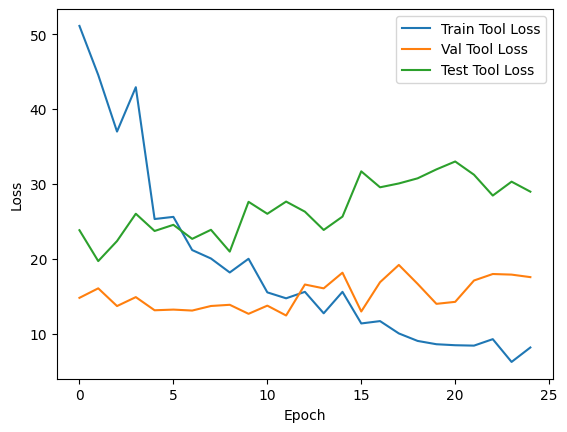

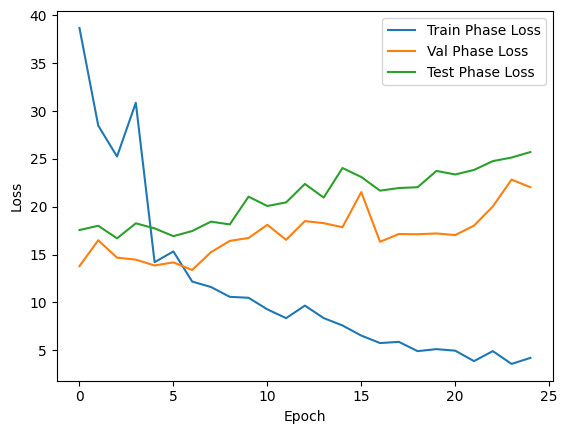

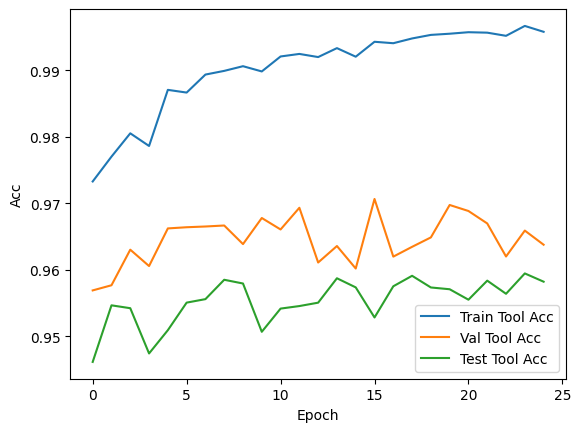

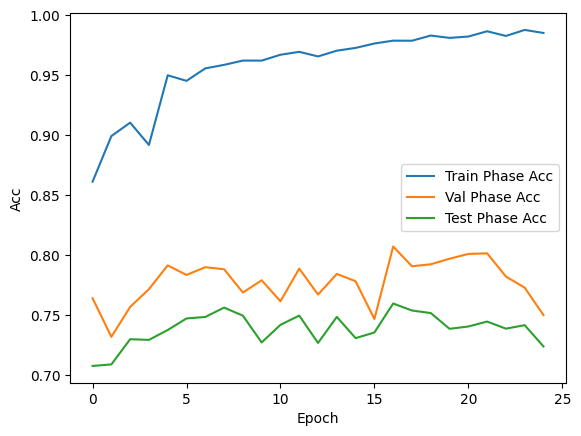

In [17]:
loss_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_loss_log.csv')
# tool loss
train_tool_loss = loss_data['Train Tool Loss']
val_tool_loss = loss_data['Val Tool Loss']
test_tool_loss = loss_data['Test Tool Loss']
plt.plot(range(len(train_tool_loss)),train_tool_loss)
plt.plot(range(len(val_tool_loss)),val_tool_loss)
plt.plot(range(len(test_tool_loss)),test_tool_loss)
plt.legend(['Train Tool Loss','Val Tool Loss','Test Tool Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# phase loss
train_phase_loss = loss_data['Train Phase Loss']
val_phase_loss = loss_data['Val Phase Loss']
test_phase_loss = loss_data['Test Phase Loss']
plt.plot(range(len(train_phase_loss)), train_phase_loss)
plt.plot(range(len(val_phase_loss)), val_phase_loss)
plt.plot(range(len(test_phase_loss)), test_phase_loss)
plt.legend(['Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

acc_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_acc_log.csv')
# tool acc
train_tool_acc = acc_data['Train Tool Acc']
val_tool_acc = acc_data['Val Tool Acc']
test_tool_acc = acc_data['Test Tool Acc']
plt.plot(range(len(train_tool_acc)), train_tool_acc)
plt.plot(range(len(val_tool_acc)), val_tool_acc)
plt.plot(range(len(test_tool_acc)), test_tool_acc)
plt.legend(['Train Tool Acc', 'Val Tool Acc', 'Test Tool Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()
# phase acc
train_phase_acc = acc_data['Train Phase Acc']
val_phase_acc = acc_data['Val Phase Acc']
test_phase_acc = acc_data['Test Phase Acc']
plt.plot(range(len(train_phase_acc)), train_phase_acc)
plt.plot(range(len(val_phase_acc)), val_phase_acc)
plt.plot(range(len(test_phase_acc)), test_phase_acc)
plt.legend(['Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()